<a href="https://colab.research.google.com/github/francobarrionuevoenv21/HPC_2025/blob/main/Final_project/CA_Implt_GPUs_HPC2025_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=0da88e6126804f85be9b2ff4b423fcfd706ddc3fac7f7f9a28b05cff3e8430d8
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 96.5 MB/s eta 0:00:00


In [3]:
# PYCUDA LIBRARIES
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [4]:
# GENERAL PURPOSES LIBRARIES
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
import math
import time

# Project Description

This project consist in the implementation of a basic Cellular Automaton (CA) for wildfire propagation that runs on GPUs using PyCUDA. The implementation performed is based on the [Julius Wons'](https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton) project. To asses the improvement of running the CA in GPUs, it is then calculated how much faster is this approach versus the sequential one.

##### **Cellular Automaton**

A [cellular automaton](https://natureofcode.com/cellular-automata/#what-is-a-cellular-automaton) is a model of a system of cell objects with the following characteristics:

*   The cells live on a grid
*   Each cell has a state. The number of possible states is typically finite. The simplest example has the two possibilities of 1 and 0 (otherwise referred to as on and off, or alive and dead).
* Each cell has a neighborhood. This can be defined in any number of ways, but it is typically all the cells adjacent to that cell.
* It is defined a transition function (rules that determine how a cell updates based on its state and its neighbors)

##### **Implementation constraints**

As it is a basic implementation, at this stage only for exploring PyCUDA capabilities, the burn probality (transition function) will be defined as a function of the NDVI.

$p_{burn} = p_0 * f_{NDVI}$

Where

*   $p_{burn}$: burn probability
*   $p_0$: base ignition probability
*   $f_{NDVI}$: multiplicative factor

# 1. Cellular Automaton (CA) implementation-Toy data

## Input data

In [5]:
# INPUT DATA DIMENSIONS
x = 64
y = 64

### NDVI

In [6]:
# NDVI TOY DATA
NDVI_toy = np.full((y, x), 0.8, dtype= np.float32)
# NOTE: Setting NDVI values in 0.8 will ensure that all pixels will be high flammable

### Cell state

In [7]:
# INITIAL STATE TOY DATA
state = np.zeros((y, x), dtype=np.int32)  # 0: non-burnt, 1: burning & 2: burnt

## NDVI data processing

### NDVI data processing functions

In [8]:
def calculate_p_den(water_thres, low_thres, high_thres, NDVI):
    '''
    This functions assigns a burn probability classification according to the
    NDVI value
    '''
    water_value = 11 # Water
    low_value = 22 # Nonflammable
    mid_value = 33 # Medium vegetation
    high_value = 44 # Dense vegetation

    ndvi_grouped = np.where(NDVI >= high_thres, high_value, NDVI)
    ndvi_grouped = np.where((NDVI >= low_thres) & (NDVI < high_thres), mid_value, ndvi_grouped)
    ndvi_grouped = np.where((NDVI >= water_thres) & (NDVI < low_thres), low_value, ndvi_grouped)
    ndvi_grouped = np.where(NDVI < water_thres, water_value, ndvi_grouped)

    return ndvi_grouped

def calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped):
    '''
    This functions assigns a burn probability according to the
    NDVI value
    '''

    p_den = np.zeros_like(ndvi_grouped, dtype=float)  # numeric array

    p_den[ndvi_grouped == 11] = den_water
    p_den[ndvi_grouped == 22] = den_low
    p_den[ndvi_grouped == 33] = den_mid
    p_den[ndvi_grouped == 44] = den_high

    return p_den

### NDVI data parameters

In [9]:
#NDVI CLASSIFICATION THRESHOLDS
## In future instances this parameters should be tunned
water_thres = 0.1
low_thres = 0.5
high_thres = 0.7

# NDVI-BURN PROBABILITY ACCORDING TO ITS CLASSIFICATION
## In future instances this parameters should be tunned
den_water = -1 # Using negative values for water ensure it can't be enflamed
den_low = -1 # These are nonflammable areas
den_mid = 0 # These are the general areas
den_high = 0.2 # Dense areas have increased change of spreading

### NDVI toy data processing

In [10]:
ndvi = NDVI_toy.copy()

# NDVI DATA CLASSIFICATION/GROUPPING
ndvi_grouped = calculate_p_den(water_thres, low_thres, high_thres, ndvi)

# BURN PROBABILITY (p_den) DATA GENERATION
'''p_den is the one that will actually be used for calculation. Not that water and nonflammable are both -1, i.e.,
nonflammable. Otherwise, the more vegetation the higher the burn probability'''
p_den = calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped).astype(np.float32)

In [11]:
p_den
# NOTE: Setting NDVI as 0.8, all pixels are classified as Dense vegetation with increased change of spreading (p_den = 0.2)

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]], dtype=float32)

## Set initial conditions

### Fire start point

In [12]:
# DEFINE FIRE START POINT IN THE CENTER
FP_lon_index = int(x/2)
FP_lat_index = int(y/2)
state[FP_lon_index, FP_lat_index] = 1 # burning: 1

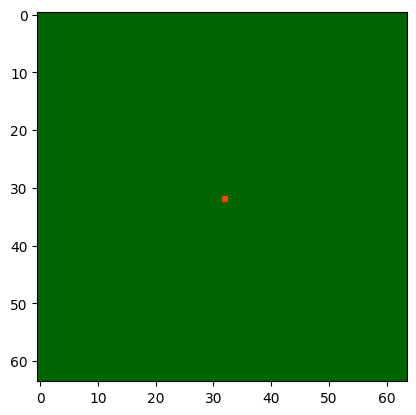

In [13]:
# T0 STATE VISUALIZATION
cmap_123 = ListedColormap(['darkgreen', 'orangered']) # green (state: 0), orangered (state: 1)
plt.imshow(state, cmap=cmap_123)
plt.show()

### Burn probability threshold

In [14]:
## In future instances this parameters should be tunned
p_h = 0.6 # Baseline threshold
p_burn = p_h*(1+p_den) # p_burn is larger as higher the ndvi value (more biomass can be serve as fuel)

### Set iterations (time-steps)

In [15]:
# NUMBER OF TIME-STEPS
T = 20

## CA GPU implementation

In [16]:
# CREATE A COPY OF THE STATE MATRIX AT T0
state_GPU = state.copy()

# SET RANDOM VALUES MATRIX (ONLY FOR GPU IMPLEMENTATION)
random_p = np.random.rand(T, x, y).astype(np.float32)

### AC implementation Kernel

In [17]:
mod = SourceModule ("""
    __global__ void compute_AC(int *state, int *old_state, float *p_burn, float *randm, int rows, int cols){
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        int i = row * cols + col;

        if (old_state[i] == 2){
              state[i] = 2;
        } else if (old_state[i] == 1) {
            state[i] = 2;
        } else if (
            (row > 0 && old_state[i - cols] == 1) || // Up
            (row < rows-1 && old_state[i + cols] == 1) || // Down
            (col > 0 && state[i - 1] == 1) || // Left
            (col < cols-1 && old_state[i + 1] == 1) || // Right
            (row > 0 && col > 0 && old_state[i - cols - 1] == 1) || // Up-left
            (row > 0 && col < cols-1 && old_state[i - cols + 1] == 1) || // Up-right
            (row < rows-1 && col > 0 && old_state[i + cols - 1] == 1) || // Down-left
            (row < rows-1 && col < cols-1 && old_state[i + cols + 1] == 1) // Down-right
        ) {

          if (randm[i] < p_burn[i]) {
            state[i] = 1;
          } else {
            state[i] = 0;
          }
        } else {
          state[i] = 0;
        }
      }
    }
    """)

### CA GPU implementation execution

In [18]:
# DEFINE ROWS AND COLS
cols = x
rows = y

# START TIME GPU IMPLEMENTATION
start_GPU = time.time()

# GET THE KERNEL FUNCTION
compute_AC = mod.get_function("compute_AC")

# ALLOCATE GPU MEMORY
state_gpu = drv.mem_alloc(state.nbytes)
state_old_gpu = drv.mem_alloc(state.nbytes)
pburn_gpu = drv.mem_alloc(p_burn.nbytes)
randm_gpu = drv.mem_alloc(random_p[0].nbytes)

# COPY INITIAL DATA TO GPU
drv.memcpy_htod(state_gpu, state_GPU)
drv.memcpy_htod(state_old_gpu, state_GPU)
drv.memcpy_htod(pburn_gpu, ndvi)

# DEFINE BLOCK AND GRID DIMENSIONS
block_dim = (32, 32, 1) # max threads per block: 1024 (32x32)
grid_dim = ((cols + block_dim[0] - 1) // block_dim[0],
           (rows + block_dim[1] - 1) // block_dim[1], 1)

# TIME LOOP. For future instances, this can be implemented with tensors instead of 2D matrices
for t in range(T):

    drv.memcpy_htod(randm_gpu, random_p[t])

    # Launch kernel
    compute_AC(
        state_gpu,
        state_old_gpu,
        pburn_gpu,
        randm_gpu,
        np.int32(rows),
        np.int32(cols),
        block=block_dim,
        grid=grid_dim
    )

    # COPY CURRENT STATE TO OLD STATE
    drv.memcpy_dtod(state_old_gpu, state_gpu, state.nbytes)


# COPY FINAL RESULTS BACK TO CPU
result = np.empty_like(state)
drv.memcpy_dtoh(result, state_gpu)

# END TIME GPU IMPLEMENTATION
end_GPU = time.time()

In [19]:
time_gpu = end_GPU-start_GPU # in seconds
print(time_gpu)

0.008744239807128906


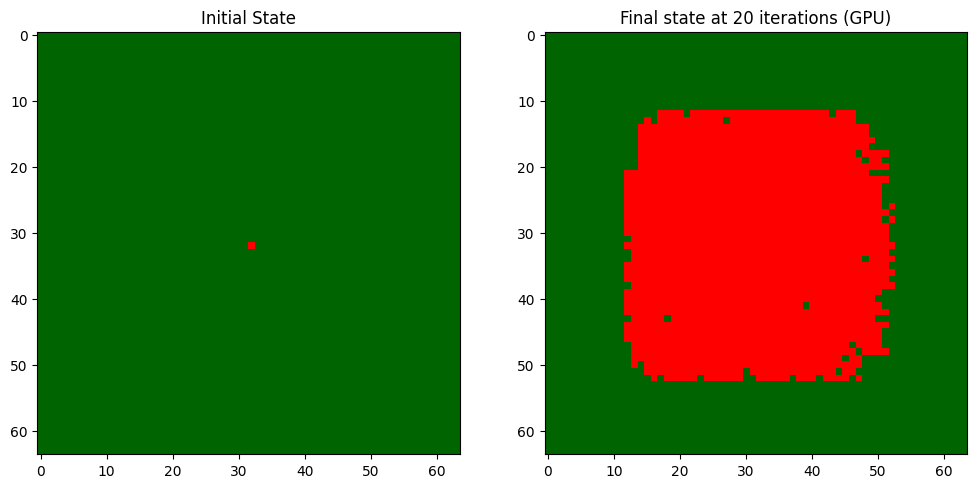

In [20]:
# CA GPU IMPLEMENTATION RESULTS VISUALIZATION FOR T: 20

cmap_123 = ListedColormap(['darkgreen', 'red']) # darkgreen: 0 (non-burnt), red: 2 (burnt)

fig, ax = plt.subplots(1, 2, figsize=(12,12))

ax[0].imshow(state_GPU, cmap=cmap_123)
ax[0].set_title("Initial State")
ax[1].imshow(result, cmap=cmap_123)
ax[1].set_title("Final state at "+str(T)+" iterations (GPU)")
plt.show()

### CA Sequential implementation execution

In [21]:
# CREATE A COPY OF THE STATE MATRIX AT T0
state_Seq = state.copy()

In [22]:
# START TIME SEQ IMPLEMENTATION
start_SEQ = time.time()

# AC IMPLEMENTATION, ITERATING OVER EACH PIXEL
for i_t in range(T):
    new_state = state_Seq.copy()  # buffer for the new step
    for i in range(y):
        for j in range(x):
            if state_Seq[i, j] == 2:
                new_state[i, j] = 2
            elif state_Seq[i, j] == 1:
                new_state[i, j] = 2
            elif (i + 1 < y and state_Seq[i+1, j] == 1) or \
                 (i - 1 >= 0 and state_Seq[i-1, j] == 1) or \
                 (j + 1 < x and state_Seq[i, j+1] == 1) or \
                 (j - 1 >= 0 and state_Seq[i, j-1] == 1) or \
                 (i + 1 < y and j + 1 < x and state_Seq[i+1, j+1] == 1) or \
                 (i - 1 >= 0 and j - 1 >= 0 and state_Seq[i-1, j-1] == 1) or \
                 (i + 1 < y and j - 1 >= 0 and state_Seq[i+1, j-1] == 1) or \
                 (i - 1 >= 0 and j + 1 < x and state_Seq[i-1, j+1] == 1):
                if np.random.rand() < p_burn[i, j]:
                    new_state[i, j] = 1
                else:
                    new_state[i, j] = 0
            else:
                new_state[i, j] = 0
    state_Seq = new_state  # update after the full step

# START TIME SEQ IMPLEMENTATION
end_SEQ = time.time()

In [23]:
time_seq = end_SEQ-start_SEQ
print(time_seq)

0.39286351203918457


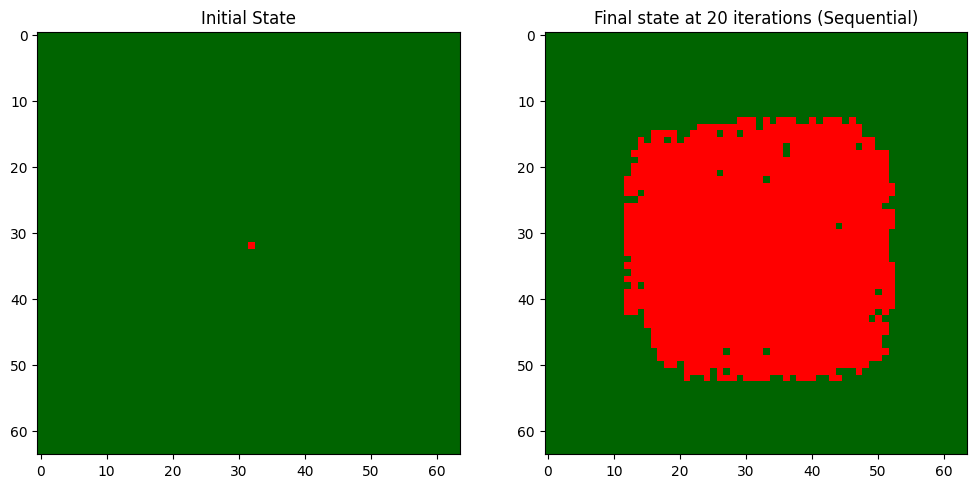

In [24]:
# CA SEQUENTIAL IMPLEMENTATION RESULTS VISUALIZATION FOR T: 20

cmap_123 = ListedColormap(['darkgreen', 'red']) # darkgreen: 0 (non-burnt), red: 2 (burnt)

fig, ax = plt.subplots(1, 2, figsize=(12,12))

ax[0].imshow(state_GPU, cmap=cmap_123)
ax[0].set_title("Initial State")
ax[1].imshow(state_Seq, cmap=cmap_123)
ax[1].set_title("Final state at "+str(T)+" iterations (Sequential)")
plt.show()

### GPU vs Sequential implemention results

In [25]:
time_effc = time_seq/time_gpu
print(f"The GPU implementation is ~{time_effc:.0f} times faster than the Sequential")

The GPU implementation is ~45 times faster than the Sequential


# 2. GPU implementation using S2 data

The image used to test the implementation on real data was obtained from Google Earth Engine. It corresponds to the median composite of a Sentinel-2 image collection. The study area was defined by a polygon centered at latitude -33.1003 and longitude -60.3694, located in the [Paraná River Delta](https://en.wikipedia.org/wiki/Paran%C3%A1_Delta) near Rosario City, Entre Ríos Province, Argentina. This area is mainly characterized by herbaceous vegetation.

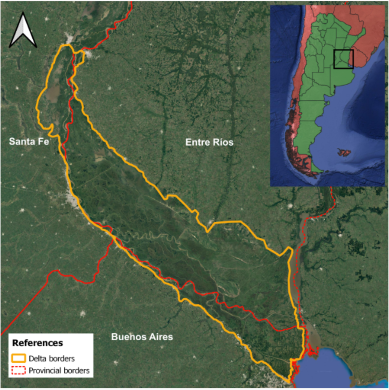

## Data importing and visualization

In [26]:
# IMPORT NDVI RASTER IMAGE FROM GITHUB REPO
!wget https://github.com/francobarrionuevoenv21/HPC_2025/raw/refs/heads/main/Final_project/NDVI_S2_jul20-sept20_10m.tif

--2025-10-05 15:24:09--  https://github.com/francobarrionuevoenv21/HPC_2025/raw/refs/heads/main/Final_project/NDVI_S2_jul20-sept20_10m.tif
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francobarrionuevoenv21/HPC_2025/refs/heads/main/Final_project/NDVI_S2_jul20-sept20_10m.tif [following]
--2025-10-05 15:24:09--  https://raw.githubusercontent.com/francobarrionuevoenv21/HPC_2025/refs/heads/main/Final_project/NDVI_S2_jul20-sept20_10m.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7215626 (6.9M) [image/tiff]
Saving to: ‘NDVI_S2_jul20-sept20_10m.tif’

NDVI_S2_jul20-sept2 100%[==================

### S2 data reading

In [27]:
delta_ndvi = rio.open('/content/NDVI_S2_jul20-sept20_10m.tif')
delta_ndvi_data = delta_ndvi.read(1)

### S2 data exploration

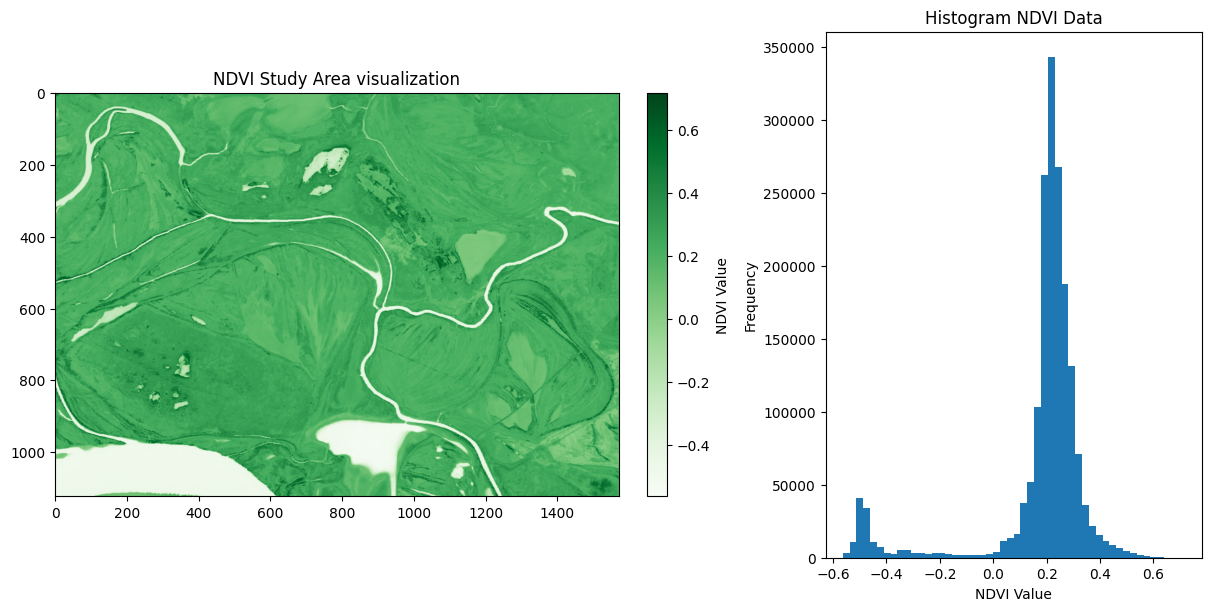

In [28]:
# DATA VISUALIZATION

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout='constrained',
                       gridspec_kw={'width_ratios': [1.5, 1]}) # Correctly unpacks figure and axes

# VISUALIZE NDVI IMAGE
im = ax[0].imshow(delta_ndvi_data, cmap='Greens') # Use the first axes for the initial state
ax[0].set_title("NDVI Study Area visualization")
im_ratio = delta_ndvi_data.shape[0]/delta_ndvi_data.shape[1]

# Add a colorbar
im_ratio = delta_ndvi_data.shape[0]/delta_ndvi_data.shape[1]
fig.colorbar(im, ax=ax[0], fraction=0.05*im_ratio, label="NDVI Value")

# NDVI VALUES HISTOGRAM
ax[1].hist(delta_ndvi_data.flatten(), bins=50)
ax[1].set_title("Histogram NDVI Data")
ax[1].set_xlabel("NDVI Value")
ax[1].set_ylabel("Frequency")

plt.show()

## Data processing

In [29]:
# NDVI thresholds

'''NOTE: threholds were redefined in order to test the implementation on real data.
In future instances this should be tunned'''

water_thres = 0.1
low_thres = 0.3
high_thres = 0.5

In [30]:
# NDVI DATA CLASSIFICATION/GROUPPING
ndvi_grouped_s2 = calculate_p_den(water_thres, low_thres, high_thres, delta_ndvi_data)
# BURN PROBABILITY (p_den) DATA GENERATION
p_den_s2 = calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped_s2).astype(np.float32)

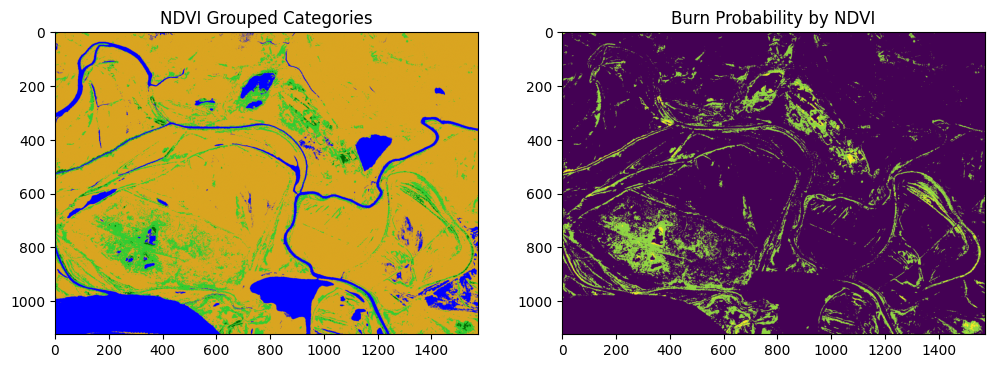

In [31]:
# DATA PROCESSING RESULTS VISUALIZATION

cmap_123 = ListedColormap(['blue', 'goldenrod', 'limegreen', 'darkgreen'])

fig, ax = plt.subplots(1, 2, figsize=(12,12)) # Correctly unpacks figure and axes

# CATEGORIES VISUALIZATION
ax[0].imshow(ndvi_grouped_s2, cmap=cmap_123) # Use the numerical data for plotting
ax[0].set_title("NDVI Grouped Categories")

# BURN PROBABILITY VISUALIZATION
ax[1].imshow(p_den_s2, cmap='viridis') # Example cmap for p_den_s2
ax[1].set_title("Burn Probability by NDVI")

plt.show()

## Data slicing

In [32]:
# DATA SLICING
ndvi_group_slc = ndvi_grouped_s2[700:950, 150:400]
p_den_s2_slc = p_den_s2[700:950, 150:400]

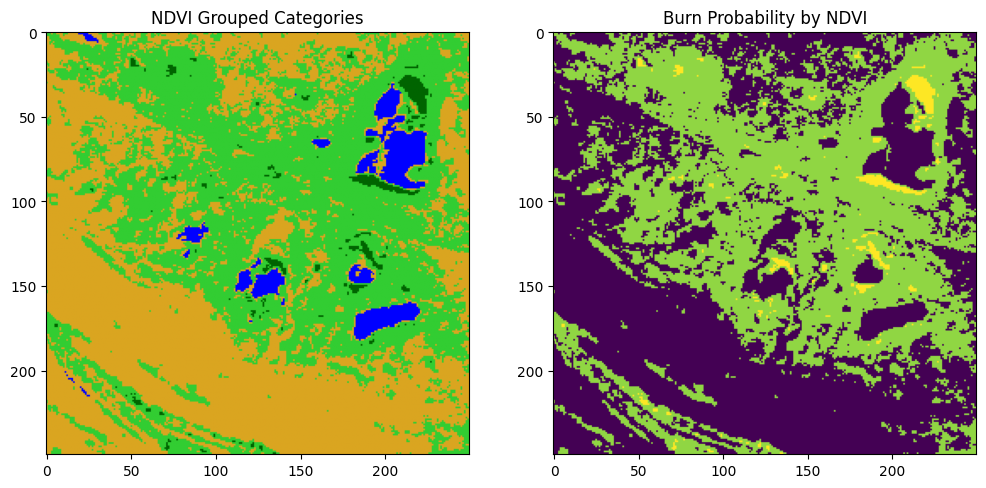

In [33]:
# DATA SLICING VISUALIZATION
cmap_123 = ListedColormap(['blue', 'goldenrod', 'limegreen', 'darkgreen'])

fig, ax = plt.subplots(1, 2, figsize=(12,12)) # Correctly unpacks figure and axes

# CATEGORIES VISUALIZATION
ax[0].imshow(ndvi_group_slc, cmap=cmap_123) # Use the numerical data for plotting
ax[0].set_title("NDVI Grouped Categories")

# BURN PROBABILITY VISUALIZATION
ax[1].imshow(p_den_s2_slc, cmap='viridis')
ax[1].set_title("Burn Probability by NDVI")

plt.show()

## Set initial conditions

In [34]:
# GET DATA DIMENSIONS
x_s2 = p_den_s2_slc.shape[1]
y_s2 = p_den_s2_slc.shape[0]

print(f"X-dimension: {x_s2}, Y-dimension: {y_s2}")

X-dimension: 250, Y-dimension: 250


In [35]:
# DEFINE STATE AT T0
state_s2 = np.zeros((y_s2, x_s2), dtype=np.int32)  # 0: non-burnt, 1: burning & 2: burnt

### Set fire points

In [36]:
# DEFINE FIRE START POINT IN THE CENTER

# FIRE POINT 1
FP01_lon_index = 140
FP01_lat_index = 170

# FIRE POINT 2
FP02_lon_index = 140
FP02_lat_index = 100

# FIRE POINT 3
FP03_lon_index = 25
FP03_lat_index = 225

state_s2[FP01_lon_index-5:FP01_lon_index+5, FP01_lat_index-5:FP01_lat_index+5] = 1
state_s2[FP02_lon_index-5:FP02_lon_index+5, FP02_lat_index-5:FP02_lat_index+5] = 1
state_s2[FP03_lon_index-5:FP03_lon_index+5, FP03_lat_index-5:FP03_lat_index+5] = 1

# MASK GENERATION
FP_mask = (state_s2 == 1)

# CHANGE STATE A T0 STATUS
ndvi_group_slc_copy =ndvi_group_slc.copy()
ndvi_group_slc_copy[FP_mask] = 55 # 55: burnt

Text(0.5, 1.0, 'NDVI Grouped Categories + Burnt Areas')

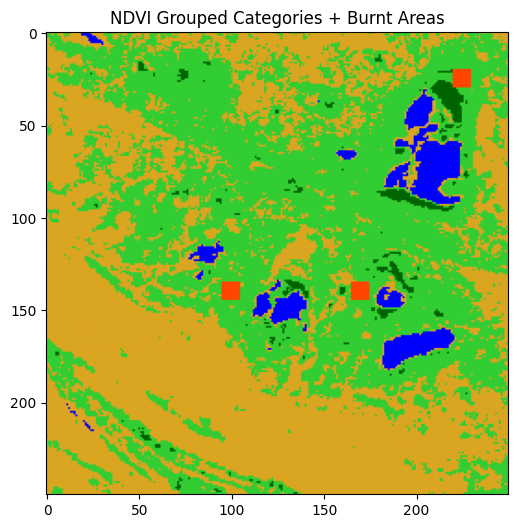

In [37]:
# CHANGED STATUS VISUALIZATION

cmap_123 = ListedColormap(['blue', 'goldenrod', 'limegreen', 'darkgreen', 'orangered'])

fig, ax = plt.subplots(figsize=(6,6)) # Correctly unpacks figure and axes

ax.imshow(ndvi_group_slc_copy, cmap=cmap_123) # Use the numerical data for plotting
ax.set_title("NDVI Grouped Categories + Burnt Areas")

### Burn probability threshold

In [46]:
## In future instances this parameters should be tunned
p_h = 0.6
p_burn_s2 = p_h*(1+p_den_s2_slc) # p_burn is larger as higher the ndvi value (more biomass can be serve as fuel)

### Set iterations (time-steps)

In [47]:
# NUMBER OF TIME-STEPS
T = 100

## CA GPU implementation (S2)

In [48]:
# CREATE A COPY OF THE STATE MATRIX AT T0
state_s2_copy = state_s2.copy()

# SET RANDOM VALUES MATRIX (ONLY FOR GPU IMPLEMENTATION)
random_p_s2 = np.random.rand(T, x_s2, y_s2).astype(np.float32)

### CA Sequential implementation execution

In [49]:
# DEFINE ROWS AND COLS
cols = x_s2
rows = y_s2

# START TIME GPU IMPLEMENTATION
start_GPU = time.time()

# GET THE KERNEL FUNCTION
compute_AC = mod.get_function("compute_AC")

# ALLOCATE GPU MEMORY
state_gpu_s2 = drv.mem_alloc(state_s2_copy.nbytes)
state_old_gpu_s2 = drv.mem_alloc(state_s2_copy.nbytes)
pburn_gpu_s2 = drv.mem_alloc(p_burn_s2.nbytes)
randm_gpu_s2 = drv.mem_alloc(random_p_s2[0].nbytes)

# Copy initial data to GPU
drv.memcpy_htod(state_gpu_s2, state_s2_copy)
drv.memcpy_htod(state_old_gpu_s2, state_s2_copy)
drv.memcpy_htod(pburn_gpu_s2, p_burn_s2)

# Define block and grid dimensions
block_dim = (32, 32, 1) # max threads by block: 1024 (32x32)
grid_dim = ((cols + block_dim[0] - 1) // block_dim[0],
           (rows + block_dim[1] - 1) // block_dim[1], 1)

temp_results = np.empty((T, rows, cols), dtype=np.int32)

# Time loop
for t in range(T):

    drv.memcpy_htod(randm_gpu_s2, (random_p_s2[t]))

    # Launch kernel
    compute_AC(
        state_gpu_s2,
        state_old_gpu_s2,
        pburn_gpu_s2,
        randm_gpu_s2,
        np.int32(rows),
        np.int32(cols),
        block=block_dim,
        grid=grid_dim
    )

    temp_result = np.empty_like(state_s2_copy)
    drv.memcpy_dtoh(temp_result, state_gpu_s2)
    temp_results[t] = temp_result

    # Copy current state to old state
    drv.memcpy_dtod(state_old_gpu_s2, state_gpu_s2, state_s2.nbytes) # Corrected: Use state_s2.nbytes


# Copy final result back to CPU
result_s2 = np.empty_like(state_s2) # Corrected: Create result_s2 with the correct shape
drv.memcpy_dtoh(result_s2, state_gpu_s2) # Corrected: Copy into result_s2

# END TIME GPU IMPLEMENTATION
end_GPU = time.time()

In [50]:
# TOTAL TIME EXECUTION
print(end_GPU-start_GPU) # in seconds

0.03702807426452637


### Results visualization

In [51]:
# DATA RESULTS PREPARATION FOR VISUALIZATION
ini_state = ndvi_group_slc_copy.copy()

FP_mask_CA = (result_s2 == 2)

end_state = ini_state.copy()
end_state[FP_mask_CA] = 55

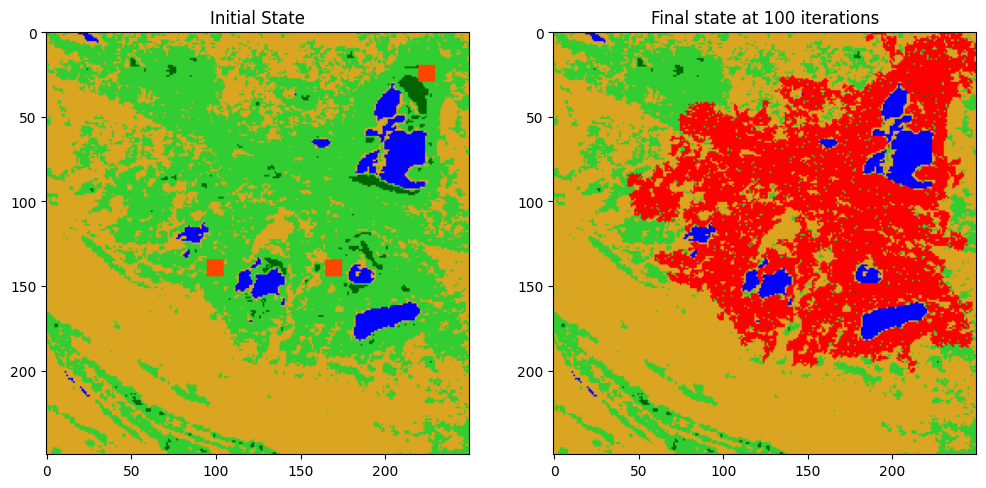

In [52]:
# INITIAL STATE AND FINAL STATE VISUALIZATION AFTER T ITERATIONS

cmap_123_02 = ListedColormap(['blue', 'goldenrod', 'limegreen', 'darkgreen', 'red'])

fig, ax = plt.subplots(1, 2, figsize=(12,12)) # Correctly unpacks figure and axes

ax[0].imshow(ini_state, cmap=cmap_123) # Use the first axes for the initial state
ax[0].set_title("Initial State")
ax[1].imshow(end_state , cmap=cmap_123_02) # Use the second axes for the final state
ax[1].set_title("Final state at "+str(T)+" iterations")
plt.show()

### CA results animation

In [53]:
# CREATE A MATRIX MERGING GROUPPED DATA BY NDVI AND BURNT PIXELS

temp_res_group = np.empty((temp_results.shape[0],
                           temp_results.shape[1],
                           temp_results.shape[2]), dtype=np.int32)

for t in range(temp_results.shape[0]):
  ndvi_group_temp = ndvi_group_slc_copy.copy()
  mask_burnt = (temp_results[t] == 2)
  ndvi_group_temp[mask_burnt] = 55
  temp_res_group[t] =  ndvi_group_temp

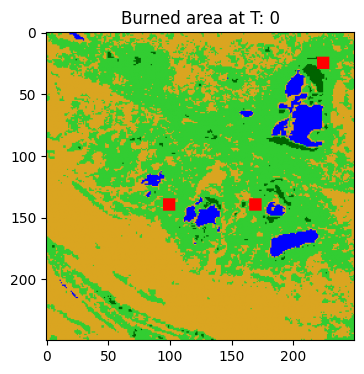

In [54]:
# CREATE ANIMATION OF RESULTS AND VISUALIZE THEM

fig, ax = plt.subplots(figsize=(4,4))

# Create the initial image for the animation
im = ax.imshow(temp_res_group[0], cmap=cmap_123_02)
ax.set_title(f"Burned area at T: 0") # Set initial title

def update(frame):
    im.set_array(temp_res_group[frame])
    ax.set_title(f"Burned area at T: {frame}")
    return [im]

ani = animation.FuncAnimation(fig, update,
                              frames=temp_res_group.shape[0],
                              interval=300,
                              blit=True)
plt.show()

In [55]:
# SAVE ANIMATION IN .GIF FORMAT
ani.save("AC_GPU_implt_animation_FINAL.gif", writer="pillow", dpi=300)

# NOTE: To see the results animation go to the GitHub repository: https://github.com/francobarrionuevoenv21/HPC_2025/tree/main/Final_project

# Conclussions and future work


A cellular automata implementation was developed to run on GPUs and compared against a sequential version using synthetic (toy) data. The GPU-based approach achieved a performance improvement of ~40× over the sequential method. The CA model was also tested with real data, successfully simulating a fire event.

For future work, the following goals are proposed:

* Replace 2D matrices with tensors.
* Incorporate land cover, wind, and topography data.
* Validate the implementation using real fire events.
* Optimize model parameters (e.g., thresholds) through ML techniques.